In [27]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()
sns.set()
# plt.style.use('fivethirtyeight')
import scienceplots
plt.style.context(['science', 'nature', 'muted'])
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import (make_scorer, confusion_matrix, 
                             accuracy_score, brier_score_loss,
                             precision_score, recall_score,
                             f1_score, cohen_kappa_score,
                             average_precision_score,
                             precision_recall_curve)
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_data_filepaths, 
                            split_features_labels_weights, 
                            load_data)


COUNTRY2 = 'full_merged_dumvar'
TRAIN_PATH2, TEST_PATH2 = get_data_filepaths(COUNTRY2)

COUNTRY = 'full_merged'
TRAIN_PATH, TEST_PATH = get_data_filepaths(COUNTRY)

In [28]:
#XGBoost
# Load and transform the training data
X_train_xgb, y_train_xgb, w_train_xgb = split_features_labels_weights(TRAIN_PATH)
# X_train_xgb = X_train_xgb.to_numpy()
# w_train_xgb = w_train_xgb.to_numpy().reshape(-1)
# y_train_xgb = y_train_xgb.to_numpy().reshape(-1)
# Load the test set
X_test_xgb, y_test_xgb, w_test_xgb = split_features_labels_weights(TEST_PATH)
# X_test_xgb = X_test_xgb.to_numpy()
# w_test_xgb = w_test_xgb.to_numpy().reshape(-1)
# y_test_xgb = y_test_xgb.to_numpy().reshape(-1)

In [29]:
model = XGBClassifier(tree_method="hist", 
                                                objective='binary:logistic',
                                                base_score=None,
                                                booster='gbtree', callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=True,
                                                eval_metric='logloss',
                                                feature_types=None, gamma=100,
                                                gpu_id=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate=0.2, max_bin=None,
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=1,
                                                max_delta_step=5, max_depth=None,
                                                max_leaves=None,
                                                min_child_weight=None,
                                                monotone_constraints=None,
                                                n_estimators=25, n_jobs=None,
                                                num_parallel_tree=None,
                                                predictor=None,
                                                random_state=None)
%time model.fit(X_train_xgb, y_train_xgb, sample_weight=w_train_xgb)

# Get an initial score
%time score = model.score(X_train_xgb, y_train_xgb)
print("In-sample score: {:0.2%}".format(score))
# feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)


# Run the model
y_pred = model.predict(X_test_xgb)
y_prob = model.predict_proba(X_test_xgb)[:,1]

# Evaluate performance and store model
# metrics = evaluation.evaluate_model(y_test_xgb, y_pred, y_prob, w_test_xgb.to_numpy().reshape(-1), 
#                                     store_model=False,
#                                     model_name='final', 
#                                     prefix=ALGORITHM_NAME,
#                                     country=COUNTRY,
#                                     model=model,
# #                                     features=feat_imps,
#                                     predict_dig_wage_rate=False)

CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 82.2 ms
CPU times: user 189 ms, sys: 0 ns, total: 189 ms
Wall time: 10 ms
In-sample score: 86.52%


In [30]:
def evaluate_model_by_demographic(model, x_test, y_test, demographic_feature):
    # Subset x_test and y_test based on the values of the demographic feature
    unique_values = x_test[demographic_feature].unique()
    subsets_x_test = [x_test[x_test[demographic_feature] == value] for value in unique_values]
    subsets_y_test = [y_test[x_test[demographic_feature] == value] for value in unique_values]
    
    # Evaluate the model's accuracy on each subset
    accuracy_scores = []
    subset_counts = []
    for i in range(len(unique_values)):
        x_subset = subsets_x_test[i].to_numpy()
        y_subset = subsets_y_test[i].to_numpy().reshape(-1)
        y_pred = model.predict(x_subset)
        accuracy_scores.append(accuracy_score(y_subset, y_pred))
        subset_counts.append(len(x_subset))
    
    # Create a dataframe of accuracy scores and their corresponding subset descriptions
    accuracy_df = pd.DataFrame({'subset_description': unique_values, 'subset_count': subset_counts, 'accuracy': accuracy_scores})
    
    return accuracy_df


In [31]:
accuracy_df = evaluate_model_by_demographic(model, X_test_xgb, y_test_xgb, 'economy')
print(accuracy_df)

   subset_description  subset_count  accuracy
0                  22            74  0.635135
1                   8            78  0.782051
2                   5            67  0.283582
3                  19            38  0.473684
4                  13            98  0.897959
5                  23            52  0.673077
6                  14            65  0.723077
7                   3            34  0.529412
8                   9            45  0.533333
9                   0            34  0.588235
10                 20            63  0.412698
11                 18            20  0.350000
12                 24            59  0.745763
13                  6            80  0.637500
14                 15            65  0.707692
15                 17           108  0.944444
16                 10            66  0.590909
17                 21            63  0.539683
18                 12            54  0.888889
19                 11            50  0.600000
20                  4            5

In [32]:
countries = ["Uganda", "Kenya", "Ghana", "Tanzania", "Namimbia", "Zambia", "Nigeria", "Congo", "Liberia",
             "Benin", "Togo", "South Sudan", "Zimbambwe", "Guinea", "Senegal", "South Africa", "Malawi",
            "Tunisia", "Mozambique", "Mali", "Egypt", "Côte d'Ivoire", "burkina Faso", "Cameroon", "Sierra Leone"]

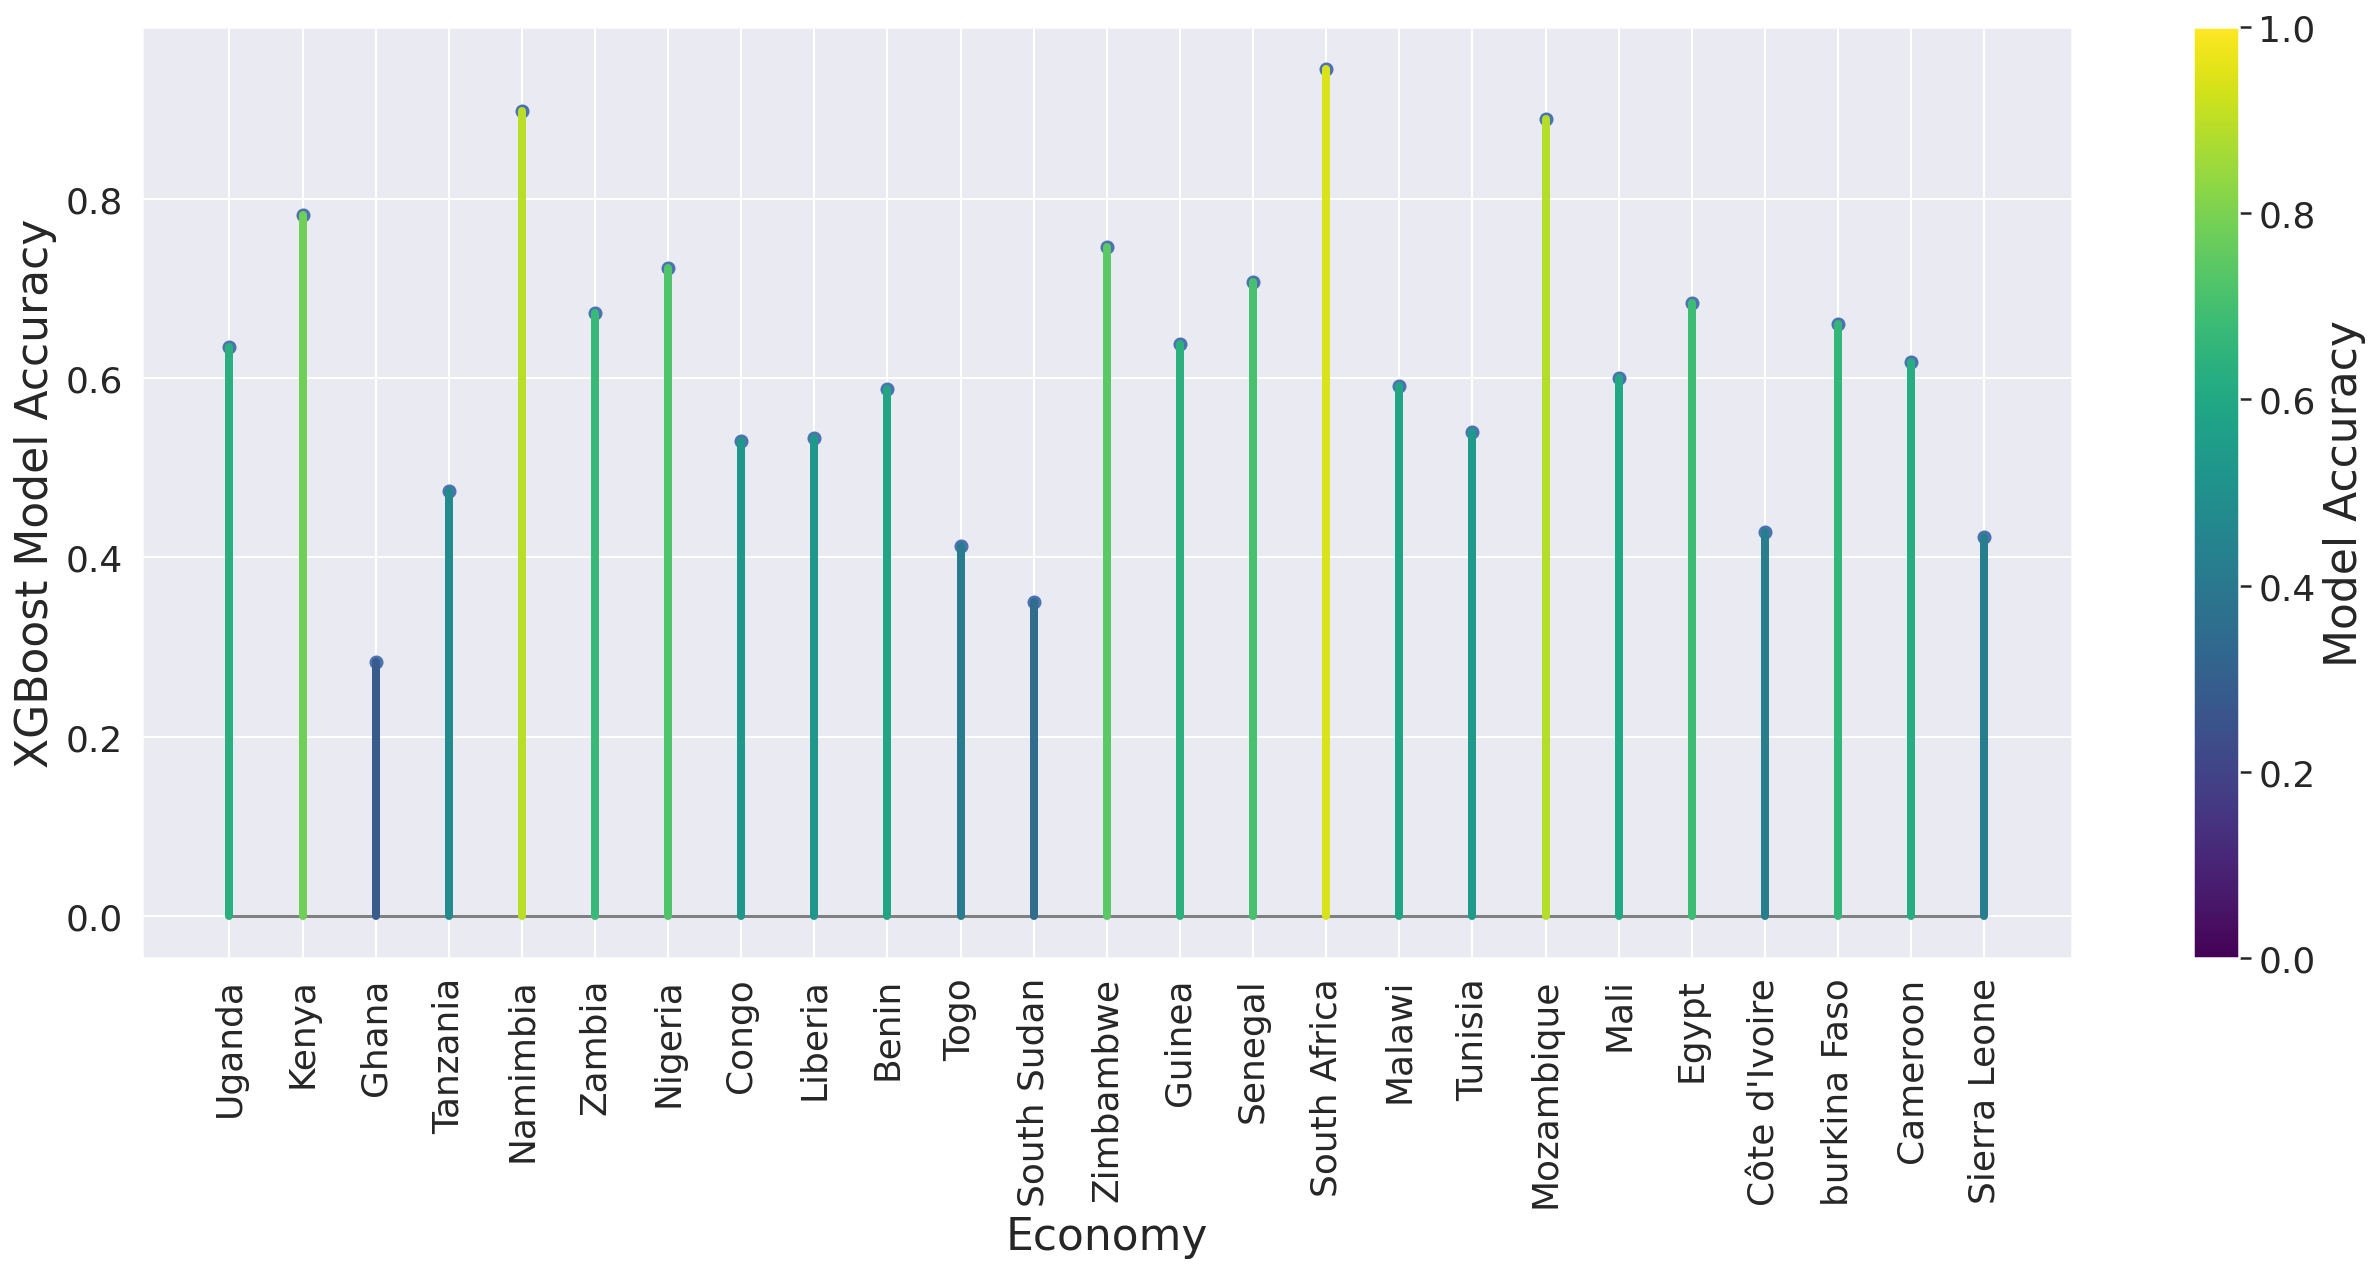

In [34]:

# Create some example data
# countries = accuracy_df.subset_description#['USA', 'Canada', 'Mexico', 'Brazil', 'Argentina']
# countries = accuracy_df.subset_description.to_list()
accuracy = accuracy_df.accuracy.to_list()

# Define a color map based on the accuracy values
cmap = plt.cm.get_cmap('viridis')
colors = cmap(accuracy)

# Create a stem plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.stem(countries, accuracy, markerfmt='o', use_line_collection=True, linefmt='grey', basefmt='grey')

# Set the color of the stems based on the accuracy values
for i, (c, a) in enumerate(zip(countries, accuracy)):
    ax.plot([c, c], [0, a], color=colors[i], linewidth=4)

# Add a color bar to show the mapping of accuracy values to colors
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Model Accuracy', fontsize=22)
cbar.ax.tick_params(labelsize=18)

# Set the title and axis labels
# ax.set_title('Accuracy by Country')
ax.set_xlabel('Economy', fontsize=22)
ax.set_ylabel('XGBoost Model Accuracy' , fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.xticks(rotation=90)
fig.set_tight_layout(True)

plt.savefig("img/economyplot.png")